# Оператор связи «Ниединогоразрыва.ком»

### Содержание
**1. [Введение](#section_id_1)**  
**2. [План работы](#section_id_2)**  
**3. [Ознакомление с данными](#section_id_3)**  
**4. [Подготовка данных](#section_id_4)**  
**5. [Исследование данных](#section_id_5)**  
**6. [Обучение модели](#section_id_6)**
   1. [Модель CatBoostClassifier](#section_id_6_1)  
   2. [Модель LogisticRegression](#section_id_6_2)  
   3. [Модель RandomForestClassifier](#section_id_6_3)  
   **7. [Итоговая модель](#section_id_7)**  
   **8. [Отчёт по решению](#section_id_8)**

<a id='section_id_1'></a>
## Введение

В данном проекте мы будем работать с данными оператора связи "Ниединогоразрыва.ком". Задача проекта - построить модель, которая будет прогнозировать отток клиентов. Если оператор сможет определить, что клиент собирается уйти, он сможет предложить ему специальные условия и промокоды, которые смогут удержать клиента и остановить его отток.

Для решения данной задачи мы будем использовать данные о договорах, персональных данных клиентов и информации об их тарифах и услугах, предоставленные оператором связи "Ниединогоразрыва.ком". Мы проведем анализ данных и построим модель машинного обучения, которая сможет прогнозировать отток клиентов с высокой точностью.

**Условия задачи:**  

На протяжении всего проекта должна быть использована константа **RANDOM_STATE = 80523**.

<a id='section_id_2'></a>
## План работы


1. Загрузить и ознакомиться с данными.
2. Изучить данные: посмотреть на первые 5 строк и размер таблиц, проверить наличие пропусков и дубликатов, оценить типы данных.
3. Обработать данные: привести названия колонок к нижнему регистру, обработать пропуски и ошибки, преобразовать типы данных, удалить дубликаты.  
4. Провести предварительный анализ данных: построить гистограммы, боксплоты, корреляцию, найти взаимосвязи в таблице.
5. Удалить или добавить признаки, которые могут улучшить качество модели.
6. Разбить данные на тренировочную, валидационную и тестовую выборки.
7. Выровнять и сбалансировать классы, если будет необходимо.
8. Обучить несколько моделей, предварительно подобрав для них лучшие параметры, нужно обязательно использовать метрики ROC-AUC и добиваться значения >0.85, accuracy.
9. Выбрать лучшую модель и проверить её работоспособность на тестовых данных.
10. Проверить модель на адекватность, например, используя DummyClassifier.
11. Оформить проект, написать выводы, отчёты и предложения по улучшению бизнес-процессов.  
12. Доработать проект.
13. Написать отчёт о проделанной работе.



<a id='section_id_3'></a>
## Ознакомление с данными

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Напишем функцию для первичного просмотра данных

In [4]:
def preview(df):
    print("Первые 5 строк таблицы:")
    display(df.head())
    print("\nРазмер таблицы:")
    display(df.shape)
    print("\nСтатистические характеристики:")
    display(df.describe())
    print("\nИнформация о данных в таблице:")
    display(df.info())
    print("\nКоличество дубликатов:")
    display(df.duplicated().sum())
    print("\nКоличество уникальных значений для каждого столбца:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()}")

In [5]:
preview(contract)

Первые 5 строк таблицы:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Размер таблицы:


(7043, 8)


Статистические характеристики:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 7043
BeginDate: 77
EndDate: 67
Type: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1585
TotalCharges: 6658


В датасете "contract" 7043 строки данных клиентов, следует обратить внимание на колонки "BeginDate" и EndDate, которые записаны в тип данных object. Возможно, эти данные должны быть переведены в тип данных datetime. Также неверно записаны данные в колонке TotalCharges, указан тип данных object, хотя сами данные записаны в формате число с точкой. Стоит отметить, что данные не приведены к нижнему регистру. Дубликаты и пропущенные данные отсутствуют.

In [6]:
preview(personal)

Первые 5 строк таблицы:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Размер таблицы:


(7043, 5)


Статистические характеристики:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 7043
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2


Датасет *personal* содержит информацию о клиентах телекоммуникационной компании, включая их пол, возраст, наличие партнера и иждивенцев, а также информацию о пенсионном статусе. Размер таблицы составляет 7043 строк и 5 столбцов, что полностью совпадает с датасетом *contacts*. Тип данных у всех колонок соответствует содержимому, то есть указан верно. Данные также не приведены к нижнему регистру. Пропусков и дубликатов нет. 

In [7]:
preview(internet)

Первые 5 строк таблицы:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Размер таблицы:


(5517, 8)


Статистические характеристики:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1402-PTHGN,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 5517
InternetService: 2
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2


Датасет *internet* содержит информацию об интернет-услугах, которыми пользуются клиенты. Каждая строка соответствует отдельному клиенту, и содержит информацию о том, какой тип интернет-сервиса используется (DSL или оптоволокно), а также информацию о том, подключены ли опции безопасности и резервного копирования данных, защищено ли устройство, предоставляется ли техническая поддержка. Также в таблице указано, смотрит ли клиент потоковое телевидение и/или кино. Размер таблицы составляет 5517 строк и 8 столбцов, что не совпадает с предыдущими датасетами, следовательно, не все клиенты пользуются данной услугой. В таблице нет дубликатов и пропусков, а данные не приведены к нижнему регистру.

In [8]:
preview(phone)

Первые 5 строк таблицы:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Размер таблицы:


(6361, 2)


Статистические характеристики:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5384-ZTTWP,No
freq,1,3390



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 6361
MultipleLines: 2


Датасет *phone* содержит информацию о том, есть ли у клиентов тип услуги - "телефония". В нем есть информация о 6361 клиенте, не содержит пропусков и дубликатов. Тип данных для всех столбцов - object. Данные не приведены к нижнему регистру.

<a id='section_id_4'></a>
## Подготовка данных

В нашем распоряжении имеются четыре датасета от компании "Ниединогоразрыва.ком". Все они не содержат дубликатов и пропусков. Однако количество клиентов, пользующихся услугами телефонии и услугами интернета, не совпадает с количеством клиентов в датасетах о договорах и персональных данных. Все четыре датасета имеют общее поле "customerID", по которому мы сможем объединить их и выявить клиентов, которые пользуются или не пользуются дополнительными услугами. Кроме этого имея объединённые таблицы, мы провёдем анализ данных.

In [9]:
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

In [10]:
preview(data)

Первые 5 строк таблицы:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Размер таблицы:


(7043, 20)


Статистические характеристики:


,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSuppor

None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 7043
BeginDate: 77
EndDate: 67
Type: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1585
TotalCharges: 6658
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
InternetService: 2
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2
MultipleLines: 2


В получившейся таблице содержится информация о 7043 клиентах. Дубликатов в таблице не обнаружено.  
Также можно заметить, что в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines есть пропущенные значения. Это говорит о том, что не все клиенты пользуются этими услугами, и данные о них не заполнены. Уникальные значения в большинстве колонок не вызывает вопросов. Также помним, что поле *BeginDate* и *EndDate*, в формате object. Рассмотрим эти колонки внимательнее.

In [11]:
display(f'Уникальные значения', data['BeginDate'].unique())
display(f'Количество уникальных значений', data['BeginDate'].nunique())

'Уникальные значения'

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

'Количество уникальных значений'

77

In [12]:
display(f'Уникальные значения', data['EndDate'].unique())
display(f'Количество уникальных значений', data['EndDate'].nunique())

'Уникальные значения'

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

'Количество уникальных значений'

67

Аномальных дат в столбцах не обнаружено.
В поле "EndDate", есть уникальное значение 'No'. Посмотрим сколько клиентов с неопределённой датой окончания контракта.

In [13]:
display('Количество клиентов с неопределённой датой окончания контракта', data['EndDate'].value_counts()['No'])

'Количество клиентов с неопределённой датой окончания контракта'

5942

5942 - довольно много клиентов. Так как даты один из целевых признаков в данном проекте, нам нужно привести 'No' к числовым значениям. Известно, что конечная дата данного датасета - 1 февраля 2020 года. Приведём значения 'No' к этой дате. 

In [14]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

Переведём даты в правильный формат *datetime* и перейдём к следующему столбцу.

In [15]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')

Внимательнее рассмотрим значения столбца *TotalCharges*.

In [16]:
unique_total_charges = data['TotalCharges'].value_counts()
display("Уникальные значения TotalCharges:", unique_total_charges)
display("Количество уникальных значений TotalCharges:", data['TotalCharges'].nunique())

'Уникальные значения TotalCharges:'

           11
20.45       6
101.0       5
255.0       4
1007.5      4
           ..
4264.75     1
286.42      1
5818.18     1
621.39      1
7546.07     1
Name: TotalCharges, Length: 6658, dtype: int64

'Количество уникальных значений TotalCharges:'

6658

В колонке "TotalCharges" имеются 11 пустых значений. Посмотрим на клиентов и попробуем выяснить ошибку.

In [17]:
empty_lines = data['TotalCharges'] == ' '
rows_with_spaces = data[empty_lines]

display(rows_with_spaces)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Одинадцать клиентов присоединились к компании "Ниединогоразрыва.ком" в день выгрузки датасета! Возможно, компания предоставляет новым клиентам 1 месяц бесплатно или похожие услуги, поэтому строки *TotalCharges* не заполнены оператором связи. Эти строки не должны оказывать влияния на обучение модели. В будущем, когда мы будем рассчитывать количество дней пользования данным оператором, мы не будем рассматривать клиентов, присоединившихся 1 февраля 2020 года, поэтому строки с пробелами решено удалить. Оставшиеся значения приведём к формату "число с точкой".

In [18]:
data = data[data['TotalCharges'] != ' ']
data['TotalCharges'] = data['TotalCharges'].astype('float')

Следующим шагом нужно разобраться с пропусками в колонках *InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines*. Если колонка *InternetService* показывает тип соединения: DSL или Fiber, то остальные поля содержат признаки "Да" или "Нет". Отметим, что поле *MultipleLines*, означает наличие параллельных линий у клиента, в данной колонке значения "NaN" заменим на "No service". В остальных случаях пропуска и отсутствия данных, можно предположить, что клиент не пользуется данными услугами. Соответственно, заменим все пропуски на "No".

In [19]:
col = ['MultipleLines']
data[col] = data[col].fillna('No service')

In [20]:
cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data[cols] = data[cols].fillna('No')

Зная даты начала и окончания контрактов, добавим столбец, показывающий длительность контракта в днях в датафрейм.

In [21]:
data['duration'] = (data['EndDate'] - data['BeginDate']).dt.days

Добавим один из важнейших столбцов проекта - показатель, ушёл клиент или нет. Дату 1 февраля 2020 года рассматривать не станем. Все показатели *EndDate*, записаные до указаной даты, будут давать показание "1" (ушли), если указана дата 2020-02-01, будет показатель "0" (остались).

In [22]:
def get_churn(row):
    if row['EndDate'] < pd.Timestamp('2020-02-01'):
        return '1'
    else:
        return '0'

data['churn'] = data.apply(get_churn, axis=1)

Добавим столбец, в котором рассчитывается количество месяцев пользования услугами. Позже, используя этот столбец, попробуем выявить взяимосвязь с уходом клиента и временем пользования услугами.

In [23]:
data['months'] = data.apply(lambda row: round(row['TotalCharges'] / row['MonthlyCharges']), axis=1)

Проверим датасет после предобработки.

In [24]:
preview(data)

Первые 5 строк таблицы:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,churn,months
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,No service,31,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,No,1036,0,36
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,No,123,0,4
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,Yes,Yes,No,No,No service,1371,0,46
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,No,153,0,5



Размер таблицы:


(7032, 23)


Статистические характеристики:


,MonthlyCharges,TotalCharges,SeniorCitizen,duration,months
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,0.162400,899.961320,30.340870
std,30.085974,2112.736199,0.368844,682.738777,23.090104
min,18.250000,19.050000,0.000000,28.000000,1.000000
25%,35.587500,439.745000,0.000000,276.000000,9.000000
50%,70.350000,1345.275000,0.000000,761.000000,26.000000
75%,89.862500,3239.317500,0.000000,1461.000000,49.000000
max,118.750000,9221.380000,1.000000,2314.000000,79.000000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object      

None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 7032
BeginDate: 76
EndDate: 67
Type: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1584
TotalCharges: 6657
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
InternetService: 3
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2
MultipleLines: 3
duration: 250
churn: 2
months: 79


Все новые данные на месте, пропусков и потерь данных нет.

<h1>Вывод</h1>

На этом предобработку данных можно считать завершённой. В данной главе, мы проделали следующую работу:
1. Объединили все четыре датасета в один.
2. Заменили конечную дату окончания контракта, у клиентов без определённой даты на 1 февраля 2020 г. (день выгрузки датасета).
3. Перевели даты в правильный формат datetime.
4. Выяснили, что 11 клиентов, которые присоединились к компании 1 февраля 2020 года, не имели записи об оплате, эти данные было решено удалить.
5. Поле "TotalCharges" перевели в формат float.
6. Заменили пропуски на "No" во всех полях кроме *MultipleLines*. Так как клиенты не пользуются данными услугами компании "Ниединогоразрыва.ком".
7. Добавили столбец, показывающий длительность контракта в днях в датафрейм.
8. Добавили признак *churn*, показывающий ушёл клиент или нет.
9. Добавлен столбец *months*, показывающий количество месяцев пользования услугами.

Переходим к исследованию данных.

<a id='section_id_5'></a>
## Исследование данных

Данные полностью готовы к исследовательскому анализу. Начнём с просмотра распределения клиентов - сколько осталось, а сколько ушло.

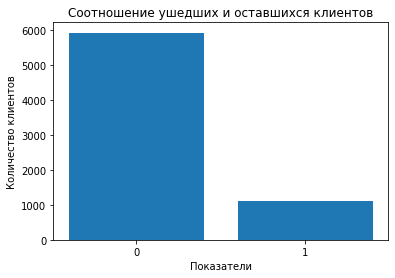

0    5931
1    1101
Name: churn, dtype: int64

In [25]:
churn_counts = data['churn'].value_counts()
plt.bar(churn_counts.index, churn_counts.values)
plt.title('Соотношение ушедших и оставшихся клиентов')
plt.xlabel('Показатели')
plt.ylabel('Количество клиентов')
plt.show()

data['churn'].value_counts()

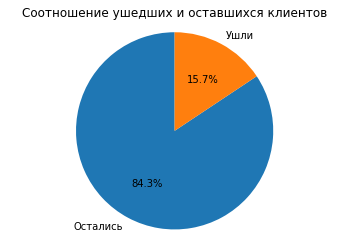

In [26]:
churn_counts = data['churn'].value_counts()
labels = churn_counts.index
sizes = churn_counts.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['Остались', 'Ушли'], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Соотношение ушедших и оставшихся клиентов')
plt.show()

По данному графику заметно, что из более 7000 клиентов, прекратили своё сотрудничество около тысячи клиентов, около 6 тысяч клиентов продолжают пользоваться услугами. Соотношение классов 1 к 6 (15.7 к 84.3 в процентном соотношении). Учтём, что присутсвует дисбаланс классов. Но в тоже время метрика, которую мы будем использовать для построения модели (AUC-ROC) не чувствительна к данной проблеме.

Построим график, который показывает среднее и медианное значения времени, через которое клиент покидает компанию.

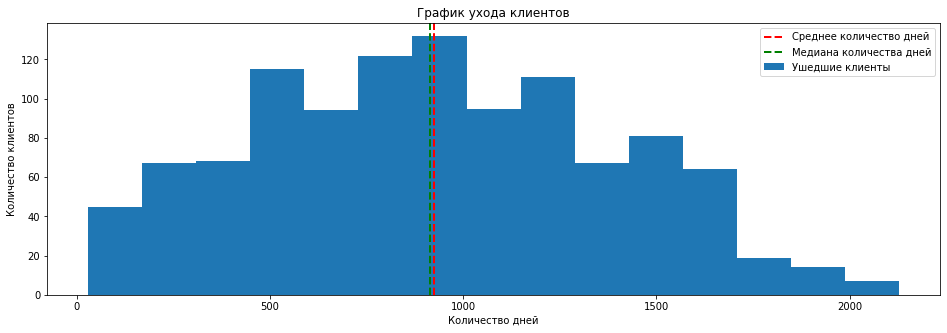

In [27]:
data_left = data.loc[data['churn'] == '1']

mean_duration = data_left['duration'].mean()
median_duration = data_left['duration'].median()

plt.figure(figsize=(16, 5))
plt.hist(data_left['duration'], bins=15, alpha=1, label='Ушедшие клиенты')
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label='Cреднее количество дней')
plt.axvline(median_duration, color='green', linestyle='dashed', linewidth=2, label='Медиана количества дней')


plt.title('График ухода клиентов')
plt.legend(loc='upper right')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов')
plt.show()

Данный график показывает, что большинство клиентов покидает компанию через, примерно, 900 дней после заключения контракта. 

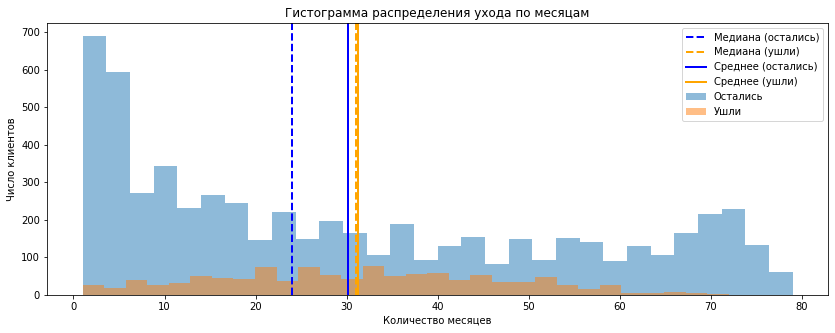

In [28]:
plt.figure(figsize=(14, 5))

months_no_churn = data[data['churn'] == '0']['months']
months_yes_churn = data[data['churn'] == '1']['months']

plt.hist(months_no_churn, bins=30, alpha=0.5, label='Остались')
plt.hist(months_yes_churn, bins=30, alpha=0.5, label='Ушли')
plt.axvline(np.median(months_no_churn), color='blue', linestyle='dashed', linewidth=2, label='Медиана (остались)')
plt.axvline(np.median(months_yes_churn), color='orange', linestyle='dashed', linewidth=2, label='Медиана (ушли)')
plt.axvline(np.mean(months_no_churn), color='blue', linestyle='solid', linewidth=2, label='Среднее (остались)')
plt.axvline(np.mean(months_yes_churn), color='orange', linestyle='solid', linewidth=2, label='Среднее (ушли)')
plt.legend(loc='upper right')
plt.xlabel('Количество месяцев')
plt.ylabel('Число клиентов')
plt.title('Гистограмма распределения ухода по месяцам')
plt.show()

Средние значения клиентов, которые остаются и уходят - практически совпадают. Клиенты начинают уходить после 30-го месяца.

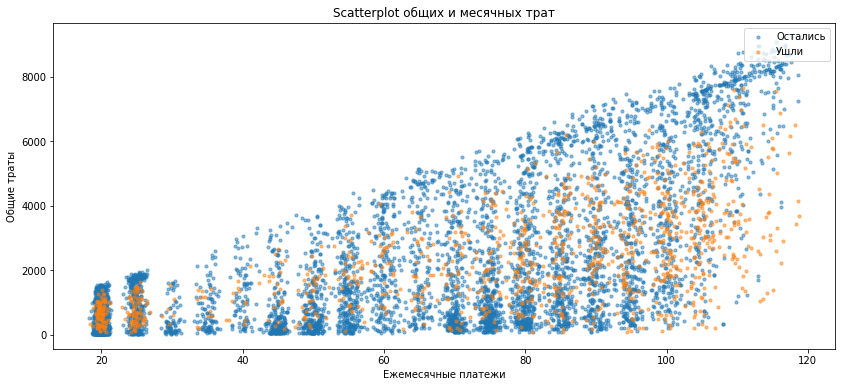

In [29]:
plt.figure(figsize=(14, 6))
plt.scatter(data[data['churn'] == '0']['MonthlyCharges'], data[data['churn'] == '0']['TotalCharges'], s=10, alpha=0.5, label='Остались')
plt.scatter(data[data['churn'] == '1']['MonthlyCharges'], data[data['churn'] == '1']['TotalCharges'], s=10, alpha=0.5, label='Ушли')
plt.legend(loc='upper right')
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Общие траты')
plt.title('Scatterplot общих и месячных трат')
plt.show()

По данному графику заметим, что многие клиенты уходят до момента, когда сумма общих трат достигнет 2000 у.е. Клиенты которые платят меньше остаются чаще, соответственно их ежемесячные платежи меньше и они остаются дольше.

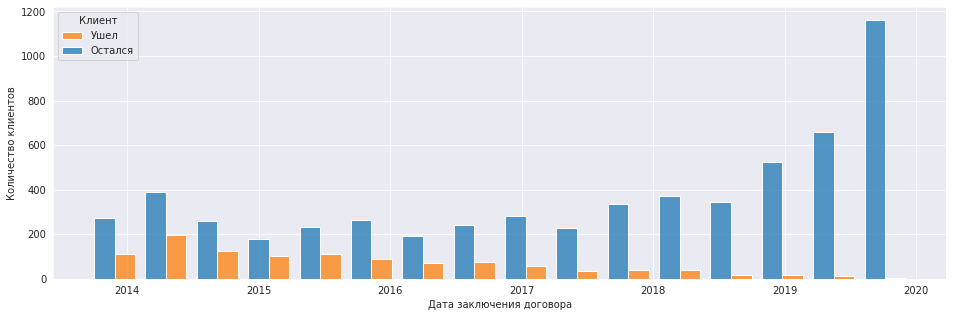

In [30]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 5))
plt.xlabel('Дата заключения договора')
plt.ylabel('Количество клиентов')

sns.histplot(data=data, x='BeginDate', hue='churn', multiple='dodge', shrink=0.8, palette=['C0', 'C1'])
plt.legend(labels=['Ушел', 'Остался'], title='Клиент', loc='upper left')
plt.show()

Данный график показывает, когда были заключены договоры с клиентами, и какое количество клиентов ушло и осталось в зависимости от даты заключения договора.  Заметно, что многие клиенты, заключившие договор в 2014-15 гг. покинули компанию. После 2016 г. ситуация с уходом клиентов улучшилась.

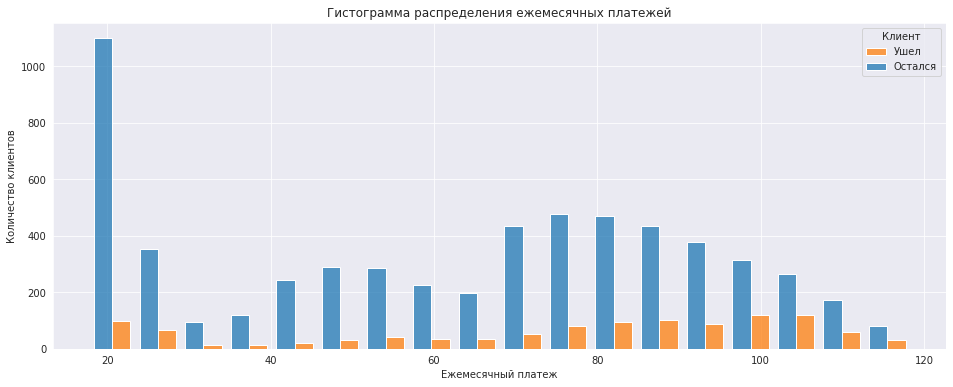

In [31]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 6))
sns.histplot(data=data, x='MonthlyCharges', hue='churn', multiple='dodge', shrink=0.8, palette=['C0', 'C1'])
plt.legend(labels=['Ушел', 'Остался'], title='Клиент', loc='upper right')
plt.title('Гистограмма распределения ежемесячных платежей')
plt.xlabel('Ежемесячный платеж')
plt.ylabel('Количество клиентов')
plt.show()

По данному графику отметим, что взаимосвязь между ценой платы за месяц и уходом клиентов существует. Клиент, который ежемесячно платит 20 условных едениц, гораздо чаще остаётся. А многие из клиентов, которые ежемесячно плятят суммы в разы выше, гораздо чаще покидают компанию. Например, из 350 клиентов, которые платят около 100 у.е., пятьдесят клиентов уходят. А из 1100 клиентов, которые плятят 20 у.е. в месяц, лишь 100 клиентов прекращают договор с компанией.

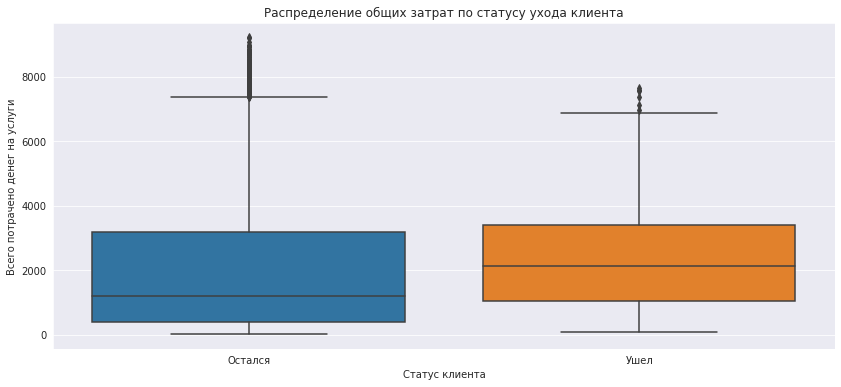

In [32]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='churn', y='TotalCharges', palette=['C0', 'C1'])
plt.title('Распределение общих затрат по статусу ухода клиента')
plt.xlabel('Статус клиента')
plt.ylabel('Всего потрачено денег на услуги')
plt.gca().set_xticklabels(labels=['Остался', 'Ушел'])
plt.show()

По данному графику заметно, что ушедшие клиенты платили больше, чем клиенты, которые остались. 

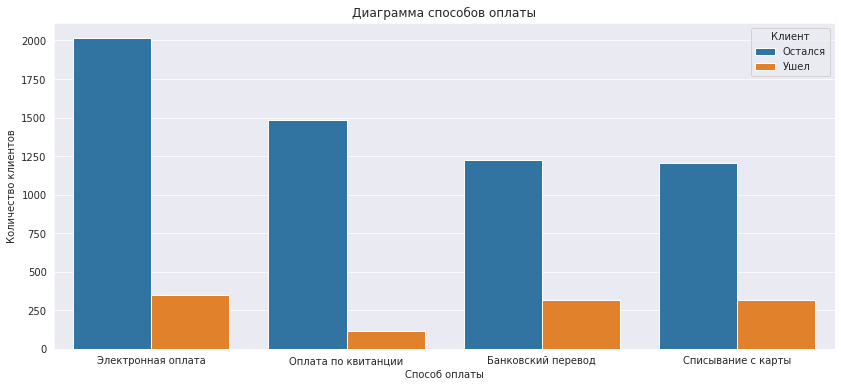

In [33]:
plt.figure(figsize=(14, 6))
sns.countplot(data=data, x='PaymentMethod', hue='churn', palette=['C0', 'C1'])
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.title('Диаграмма способов оплаты')
plt.legend(labels=['Остался', 'Ушел'], title='Клиент', loc='upper right')
plt.gca().set_xticklabels(labels=['Электронная оплата', 'Оплата по квитанции', 'Банковский перевод' ,'Списывание с карты'])
plt.show()

Отметим, что меньше всего клиенты клиенты покидают компанию, если они платят традиционнным методом, по остальным трём методам оплаты распределение ухода, в целом, одинаковое.

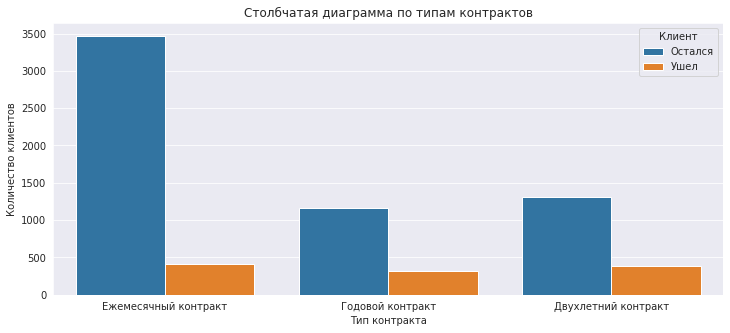

In [34]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 5))
sns.countplot(data=data, x='Type', hue='churn', palette=['C0', 'C1'])
plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.title('Столбчатая диаграмма по типам контрактов')
plt.legend(labels=['Остался', 'Ушел'], title='Клиент', loc='upper right')
plt.gca().set_xticklabels(labels=['Ежемесячный контракт', 'Годовой контракт', 'Двухлетний контракт'])
plt.show()

Большая часть ушедших клиентов заключали ежемесячный контракт, чуть меньше пользователей покинули компанию по истечении двухлетнего контракта, и немного меньше заключали однолетний контракт. Также отметим, что большинство клиентов заключают ежемесячный контракт.

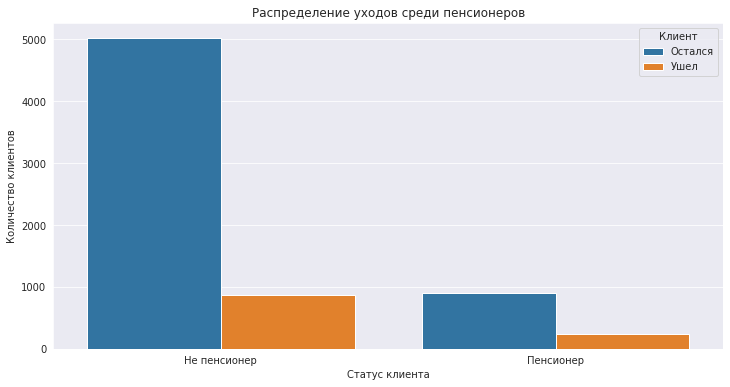

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='SeniorCitizen', hue='churn', palette=['C0', 'C1'])
plt.xlabel('Статус клиента')
plt.ylabel('Количество клиентов')
plt.title('Распределение уходов среди пенсионеров')
plt.legend(labels=['Остался', 'Ушел'], title='Клиент', loc='upper right')
plt.gca().set_xticklabels(labels=['Не пенсионер', 'Пенсионер'])
plt.show()

По данному графику, можно отметить, что большая часть клиентов компании не являются пенсионерами. Среди граждан пенсионного возраста, большая часть остаётся и пользуется услугами, уходит лишь небольшая часть.

Попробуем построить график наличия дополнительных телефонных линий и факта ухода пользователя.

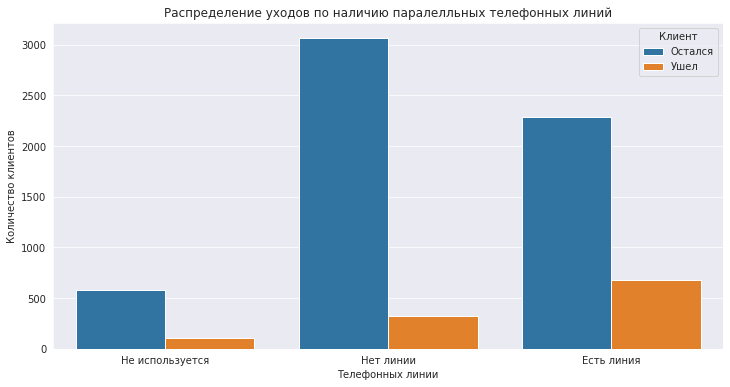

In [36]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='MultipleLines', hue='churn', palette=['C0', 'C1'])
plt.xlabel('Телефонных линии')
plt.ylabel('Количество клиентов')
plt.title('Распределение уходов по наличию паралелльных телефонных линий')
plt.legend(labels=['Остался', 'Ушел'], title='Клиент', loc='upper right')
plt.gca().set_xticklabels(labels=['Не используется', 'Нет линии', 'Есть линия'])
plt.show()

Данный график показывает, что небольшое количество клиентов не пользуется телефонными линиями, а количество ушедших клиентов в данной категории около 100 человек. Большинство клиентов, использующих сервис, не имеют дополнительных линий, при этом число ушедших клиентов в этой категории немного выше, чем в предыдущей категории. У большинства пользователей, которые ушли, было несколько телефонных линий, однако количество этих пользователей не превышает количество оставшихся пользователей в данной категории

Изучим соотношение значений на корреляционной матрице.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'duration', 'months']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7032. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


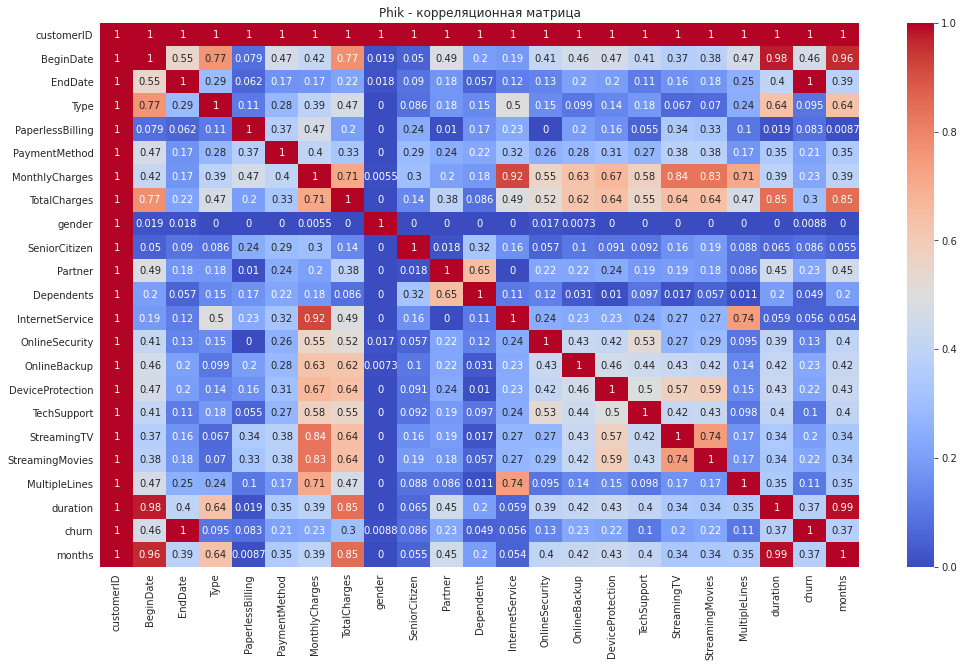

In [37]:
corr_matrix = data.phik_matrix()

plt.figure(figsize=(17, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phik - корреляционная матрица')
plt.show()

Выводы по корреляции:

* Не обнаружено ярко выраженных факторов, которые бы коррелировали с уходом клиента или влияли на него.
* Наблюдается устойчивая связь между услугами интернета, возможностью просмотра ТВ и видео онлайн и ежемесячной оплатой.
* Пол клиента не влияет на уход или выбор каких-либо услуг.
* Наличие партнёра коррелирует с наличием иждивенцев.
* Многие клиенты, которые пользуются интернетом, имеют дополнительные телефонные линии.
* Многие пользователи устанавливают программы для защиты девайсов и пользуются услугами резервного копирования данных.
* Все столбцы со указанием дат и временем кореллируют между собой.

<h1>Вывод</h1>

* Соотношение ушедших к оставшимся клиентов (84 к 16).
* Ушедшие клиенты платили больше чем клиенты, которые остались.  
* Клиенты прекращают пользоваться услугами компании после, примерно, двух лет пользования сервисом.
* Если клиент на долгосрочном контракте с компанией, то он скорее останется. В тоже время, клиенты, которые заключают ежемесячный контракт, чаще покидают компанию.
* Клиенты на ежемесячном контакте платят больше. Таким образом, цена, одна из основных причин ухода клиентов. 

<a id='section_id_6'></a>
## Обучение модели

В данной главе обучим следующие модели:  

**1) CatBoostClassifier  
2) LogisticRegression  
3) RandomForestClassifier**

Сравним их показатели **AUC-ROC** и **accuracy**, выберем лучшую, и проверим показатели на тестовых данных. Будем учитывать, что модели: 
 * Catboost не требует кодирования данных, но ей необходимо передать категориальные значения.
 * LogisticRegression требует кодировку данных по OHE.
 * RandomForestClassifier требует кодировку данных по OE. 
 Выполним необходимые действия перед непосредственным обучением.

Для корректной работы модели, необходимо перевести колонки признаков в категориальный класс.

In [38]:
cols_to_convert = ["Type", "PaperlessBilling", "PaymentMethod", "gender", "Partner", "Dependents", 
                   "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", 
                   "StreamingTV", "StreamingMovies", "MultipleLines", "SeniorCitizen", 'churn']

data[cols_to_convert] = data[cols_to_convert].astype("category")

Проверим данные

In [39]:
preview(data)

Первые 5 строк таблицы:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,churn,months
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,No service,31,0,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,No,1036,0,36
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,No,123,0,4
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,Yes,Yes,No,No,No service,1371,0,46
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,No,153,0,5



Размер таблицы:


(7032, 23)


Статистические характеристики:


,MonthlyCharges,TotalCharges,duration,months
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320,30.340870
std,30.085974,2112.736199,682.738777,23.090104
min,18.250000,19.050000,28.000000,1.000000
25%,35.587500,439.745000,276.000000,9.000000
50%,70.350000,1345.275000,761.000000,26.000000
75%,89.862500,3239.317500,1461.000000,49.000000
max,118.750000,9221.380000,2314.000000,79.000000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   category      
 4   PaperlessBilling  7032 non-null   category      
 5   PaymentMethod     7032 non-null   category      
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   category      
 9   SeniorCitizen     7032 non-null   category      
 10  Partner           7032 non-null   category      
 11  Dependents        7032 non-null   category      
 12  InternetService   7032 non-null   category      
 13  OnlineSecurity    7032 non-null   category    

None


Количество дубликатов:


0


Количество уникальных значений для каждого столбца:
customerID: 7032
BeginDate: 76
EndDate: 67
Type: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1584
TotalCharges: 6657
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
InternetService: 3
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2
MultipleLines: 3
duration: 250
churn: 2
months: 79


Подготовим целевой признак и признаки для обучения модели. Целевой признак, выясняет, уйдет клиент или нет, в нашем случае за этот отвечает поле 'churn'. Признаки, которые решено удалить: 'customerID', который не несёт большой значимости для обучения, даты начала и окончания контрактов, месяцы пользования услугами, пол клиентов.

In [40]:
target = data['churn']
features = data.drop(columns=['churn', 'customerID', 'BeginDate', 'EndDate', 'gender', 'months'])

Проверим признаки

In [41]:
display(target.head())
display(target.shape)

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: category
Categories (2, object): ['0', '1']

(7032,)

In [42]:
preview(features)

Первые 5 строк таблицы:


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,No,DSL,No,Yes,No,No,No,No,No service,31
1,One year,No,Mailed check,56.95,2071.84,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No service,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,No,No,Fiber optic,No,No,No,No,No,No,No,153



Размер таблицы:


(7032, 17)


Статистические характеристики:


,MonthlyCharges,TotalCharges,duration
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320
std,30.085974,2112.736199,682.738777
min,18.250000,19.050000,28.000000
25%,35.587500,439.745000,276.000000
50%,70.350000,1345.275000,761.000000
75%,89.862500,3239.317500,1461.000000
max,118.750000,9221.380000,2314.000000



Информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7032 non-null   category
 1   PaperlessBilling  7032 non-null   category
 2   PaymentMethod     7032 non-null   category
 3   MonthlyCharges    7032 non-null   float64 
 4   TotalCharges      7032 non-null   float64 
 5   SeniorCitizen     7032 non-null   category
 6   Partner           7032 non-null   category
 7   Dependents        7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  MultipleLines     7032 non-null   catego

None


Количество дубликатов:


12


Количество уникальных значений для каждого столбца:
Type: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1584
TotalCharges: 6657
SeniorCitizen: 2
Partner: 2
Dependents: 2
InternetService: 3
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2
MultipleLines: 3
duration: 250


Признаки были успешно разделены без потерь. Они были разделены на целевой и остальные, после чего все, кроме числовых, были преобразованы в тип данных "category". Далее мы создадим обучающую и тестовую выборки в соотношении 0,75:0,25.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=80523)

Создаем объекты OneHotEncoder для преобразования категориальных признаков. А также проверяем их.

In [44]:
categoric_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents']

numeric_features = ['MonthlyCharges', 'TotalCharges', 'duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='error'), categoric_features)])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

Проверка на пропущенные значения

In [45]:
nan_found = False
for dataset in [X_train_encoded, X_test_encoded]:
    nan_rows, nan_cols = np.where(np.isnan(dataset))
    if len(nan_rows) > 0:
        nan_found = True
        break
if nan_found:
    print('Найдены пропущенные значения')
else:
    print('Пропущенных значений не найдено')

Пропущенных значений не найдено


In [46]:
X_train_encoded.shape

(5274, 22)

In [47]:
X_test_encoded.shape

(1758, 22)

Данные для логистической регрессии готовы.  

Ниже напишем код для кодировки признаков в Ordinal Encoder для модели случайный лес.

In [48]:
oe = OrdinalEncoder(handle_unknown='ignore')
X_train_encoded_oe = oe.fit_transform(X_train)
X_test_encoded_oe = oe.transform(X_test)

In [49]:
display(X_train_encoded_oe.shape)
display(X_test_encoded_oe.shape)

(5274, 17)

(1758, 17)

In [50]:
nan_found = False
for dataset in [X_train_encoded_oe, X_test_encoded_oe]:
    nan_rows, nan_cols = np.where(np.isnan(dataset))
    if len(nan_rows) > 0:
        nan_found = True
        break
if nan_found:
    print('Найдены пропущенные значения')
else:
    print('Пропущенных значений не найдено')

Пропущенных значений не найдено


Данные закодировались. ропущенных значений не найдено.

Обучим несколько моделей. В качестве первой модели используем **CatBoostClassifier** подготовим категориальные признаки для модели. Подберём лучшие параметры для обучения модели с помощью системы Gridsearch, учтём, что метрики которые важны заказчику - ROC-AUC и accuracy. 

In [51]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Partner', 'Dependents']

Создадим словарь для записи лучших параметров обучения, а после обучения моделей построим таблицу и выберем лучшую модель.

In [52]:
test_score = {}

<a id='section_id_6_1'></a>
### Модель CatBoostClassifier

```python
model_cat = CatBoostClassifier(logging_level='Silent', random_state=80523, cat_features=categorical_features)


param_grid = {'learning_rate': np.arange(0.01, 0.21, 0.04),
              'iterations': range(50, 301, 50),
              'depth': [3, 10, 2],
              
             }


grid_search = GridSearchCV(model_cat, param_grid, cv=4, scoring='roc_auc')


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_

best_model_cat = grid_search.best_estimator_


accuracy_train = best_model_cat.score(X_train, y_train)

predict_train = best_model_cat.predict_proba(X_train)[:, 1]

roc_auc_train = roc_auc_score(y_train, predict_train)

print("Лучшие параметры для обучения:", best_params)
print("ROC AUC на кросс-валидации:", grid_search.best_score_)
```

```python
#Код ревьюера

grid_search .best_score_
```

In [53]:
cat_best_params = {'depth': 3,
                   'iterations': 300,
                   'learning_rate': 0.17
                  }

In [54]:
test_score['CatBoostClassifier'] = 0.8794183217501237

<a id='section_id_6_2'></a>
### Модель LogisticRegression

```python
pipe_lr = Pipeline([('clf', LogisticRegression(random_state=80523, max_iter=400))])


param_grid = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

grid_lr = GridSearchCV(estimator=pipe_lr, 
                     param_grid=param_grid, 
                     scoring='roc_auc',
                     cv=4)

grid_lr.fit(X_train_encoded, y_train)

best_model = grid_lr.best_estimator_
best_accuracy = best_model.score(X_train_encoded, y_train)
best_y_pred = best_model.predict_proba(X_train_encoded)[:, 1]
best_roc_auc = roc_auc_score(y_train, best_y_pred)

print("Лучшие параметры для обучения:", grid_lr.best_params_)
print("ROC AUC на кросс-валидации:", grid_lr.best_score_)
```

In [55]:
lr_best_params = {'clf__C': 100,
                  'clf__solver': 'liblinear'}

In [56]:
test_score['LogReg'] = 0.7610384316429875

<a id='section_id_6_3'></a>
### Модель RandomForestClassifier

```python
rf = RandomForestClassifier(random_state=80523)

pipeline = Pipeline([
    ('rf', rf)
])

parameters = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__class_weight': ['balanced', None]
}

scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}


search = GridSearchCV(
    pipeline, 
    parameters, 
    cv=4, 
    n_jobs=-1, 
    scoring=scoring, 
    refit='roc_auc'
)

search.fit(X_train_encoded_oe, y_train)

print('Лучшие параметры для обучения:', search.best_params_)
print("ROC AUC на кросс-валидации:", search.best_score_)
```

In [57]:
rf_best_params = {'rf__class_weight': 'None',
                  'rf__max_depth': 5,
                  'rf__min_samples_leaf': 1,
                  'rf__n_estimators': 100
}

In [58]:
test_score['RandomForestClassifier'] = 0.8263201378838062

In [59]:
df = pd.DataFrame.from_dict(test_score, orient='index', columns=['ROC AUC'])

display(df)

,ROC AUC
CatBoostClassifier,0.879418
LogReg,0.761038
RandomForestClassifier,0.826320


После обучения трёх моделей, заметно, что лучше всего с данной задачей справляется бустинговая модель. У модели высокий ROC-AUC. У модели случайного леса показатель ниже, худший показатель из трёх у логистической регрессии, всего 0.76. Таким образом, лучшая модель **CatBoostClassifier** с показателем **ROC-AUC 0.87**. Проверим как модель справится с задачей на тестовой выборке.

<a id='section_id_7'></a>
## Итоговая модель

In [60]:
final_model = CatBoostClassifier(logging_level='Silent', **cat_best_params, random_state=80523,
                                 cat_features=categorical_features)

final_model.fit(X_train, y_train)


accuracy = final_model.score(X_test, y_test)


y_pred = final_model.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, y_pred)


display("Точность:", accuracy)
display("ROC AUC:", roc_auc)


'Точность:'

0.9027303754266212

'ROC AUC:'

0.8965345246356698

Итоговая модель отлично справилась с задачей показав высокие результаты. Значение **точности равно 0,9027**, что означает, что модель правильно классифицировала 90.2% всех данных, значение **ROC-AUC равное 0,8965** говорит о том, что модель с высокой точностью может различать положительные и отрицательные классы.  
Рассмотрим эти значения подробнее на графиках, но прежде проверим модель, сравнив её со случайной моделью DummyClassifier.

In [61]:
dummy = DummyClassifier(strategy='stratified')

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])
print("Точность:", accuracy)
print("ROC-AUC:", roc_auc)

Точность: 0.7474402730375427
ROC-AUC: 0.49960454341347915


Показатель ROC-AUC случайной модели около 0.50. Это означает, что Dummy угадывает значения случайно, а наша же модель права в 89% случаев.

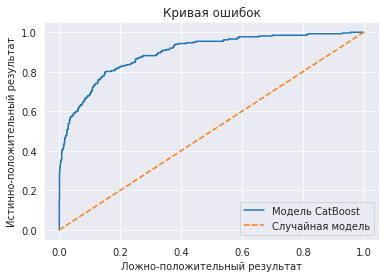

In [62]:
y_pred_proba = final_model.predict_proba(X_test)[:,1]
y_test_int = y_test.astype(int)
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred_proba)

plt.plot(fpr, tpr, label='Модель CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.xlabel('Ложно-положительный результат')
plt.ylabel('Истинно-положительный результат')
plt.title('Кривая ошибок')
plt.legend()
plt.show()

Качество нашей модели на кривой ошибок намного выше качества случайной модели. График модели CatBoost выше, Модель предскажет верный ответ горазда чаще случайной модели.

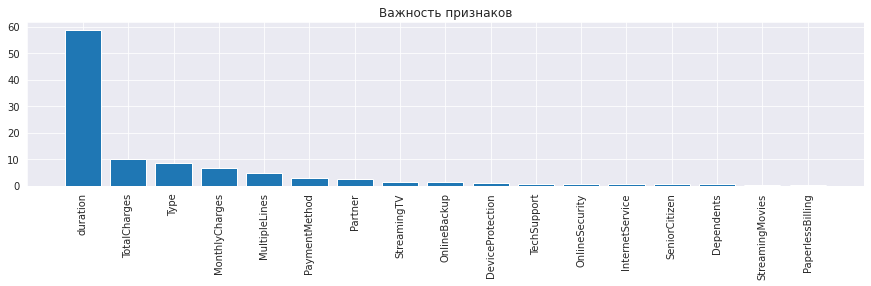

In [63]:
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns

sorted_index = feature_importance.argsort()[::-1]
sorted_feature_names = feature_names[sorted_index]

plt.figure(figsize=(15, 3))
plt.bar(range(len(feature_importance)), feature_importance[sorted_index])
plt.xticks(range(len(feature_importance)), sorted_feature_names, rotation=90)
plt.title("Важность признаков")
plt.show()

Самые важные признаки, который использовала модель *Catboost* это:
* duration (признак созданный нами), включающий в себя количество дней, которые клиент провёл с компанией;
* TotalCharges (сколько всего денег клиенты потратили на услуги);
* Type - тип оплаты: ежемесячный, ежегодный, раз в два года.
* MonthlyCharges - сумма, которую клиенты платят за услуги ежемесячно.
* Также один из признаков, который помогает подсказать уйдёт клиент или нет это наличие ведения паралелльных линий во время звонка.

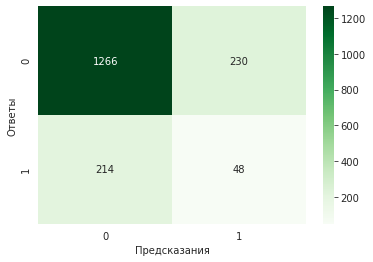

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)

# округление значений до 2 знаков после запятой
conf_matrix_rounded = np.round(conf_matrix, decimals=2)

# построение графика
sns.heatmap(conf_matrix_rounded, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

Данная матрица показывает как модель предсказывает класс клиента - уйдет ли он или нет.
* 1268 - это количество правильно предсказанных отрицательных случаев (True Negatives), т.е. количество оставшихся клиентов, которые были верно предсказаны моделью.
* 228 - это количество ложно предсказанных положительных случаев (False Positives), т.е. количество оставшихся клиентов, которые были неверно предсказаны моделью как ушедшие.
* 214 - это количество ложно предсказанных отрицательных случаев (False Negatives), т.е. количество ушедших клиентов, которые были неверно предсказаны моделью как оставшиеся.
* 48 - это количество правильно предсказанных положительных случаев (True Positives), т.е. количество ушедших клиентов, которые были верно предсказаны моделью.

<h1>Вывод</h1>

Модель Catboost дала хорошие результаты, правильно определившие 89% тестовых примеров с точностью 90%.  

В ходе обучения модель обратила внимание на такие признаки как месячная оплата, тип оплаты. Это говорит о том, что эти признаки могут являться важными факторами для прогнозирования ухода клиента.

Из анализа было установлено, что клиент, склонный к уходу, чаще всего заключает ежемесячные контракты, не оплачивает услуги по квитанциям и пользуется современными методами оплаты. Соответственно, важно обращать на эти факторы особое внимание, чтобы удержать клиентов.

Также рекомендация заказчику - устраивать акции или стараться заключать с клиентами двухлетние контракты. Это может помочь клиентам остаться и увеличить общее количество лояльных клиентов.

<a id='section_id_8'></a>
## Отчёт по решению

Большинство поставленных пунктов плана были выполнены в ходе решения задачи. Некоторые некритичные решения были отклонены во время решения задачи, такие как перевод наименований столбцов к нижнему регистру, что, в каком-то смысле, облегчило задачу, так как названия признаков было лучше видно, и они не сливались в одно слово. Было решено отказаться от ручной балансировки классов, так как выбранная метрика не чувствительна к дисбалансу, а модели могут разобраться с дисбалансом самостоятельно. Было решено разбить датасет на две части для обучения и тестирования вместо трёх, так как во время обучения использовалась система кросс-валидации.  

Во время работы возникло несколько серьёзных проблем. Первая проблема была решена самостоятельно, её суть заключалась в неправильном обучении данных. Я обучал модель CatBoost на закодированных через OHE признаках. Во время проверки кода, я обнаружил данную проблему, сверился с теорией на Яндекс.Практикуме, прочитал несколько [статей](https://habr.com/ru/companies/otus/articles/527554/) о работе CatBoost и пришел в выводу, что совершил ошибку. Код был благополучно исправлен. Следующей проблемой было переобучивание модели. Я неправильно указывал learning rate в GridSearch во время поиска лучших параметров модели. Как известно, чем ближе значение к еденице, тем выше скорость обучения, но в тоже время, велика вероятность переобучивания модели. Мои значения ROC-AUC были близки к еденице, что подсказывало мне либо об утечки данных, либо о наличии другой ошибки. Но и в этот раз помогла теория (Спринт 14 - Численные методы - Градиентный бустинг - Регуляризация градиентного бустинга), [источник](https://practicum.yandex.ru/trainer/data-scientist/lesson/ec6393d0-edda-4c05-ba29-5e951f7c90e5/). Проблема была решена понижением параметра learning rate, в моём случае это не повлияло на скорость, но модель перестала переобучиваться.  

Следующие ошибки произошли из-за невнимательности, а именно, я не указал параметр drop='first' в one-hot-encoder. Что было указано и в [теории](https://practicum.yandex.ru/trainer/data-scientist/lesson/84e25bbb-46d1-42ec-8c27-258e663ee5e4/), и в предыдущих проектах. Исправлено благодаря тимлиду.  

Последней проблемой была неверность поиска оценки AUC-ROC, выявить оценку было необходимо с помощью кросс-валидации, в моём же случае, поиск осуществлялся через обучающую выборку. Данная проблема также была исправлена с помощью тимлида.

Самыми главными шагами, на мой взгляд, было созднание признаков. Датасет выданный заказчиком не имел столбцы, которые показывали статус клента (ушел или нет), но была информация о начале и окончании контрактов, что позволило, сначала высчитать длительность контрактов, а затем и присвоению статуса клиенту. Также это поле стало целевым признаком для обучения и тестирования модели.  

При выборе признаков было решено оставить практически все, которые имели какую либо информацию о клиенте. Сам датасет не велик, около 7000 строк. На мой взгляд, если передать модели больше данных, модель обучится лучше и, не обманет, заказчика на практике. Признаки которые было решено удалить: *customerID*, так как он несёт ценность лишь для заказчика, но для обучения модели этот признак не нужен. Также были удалены дублирующий признак *month*, даты начала и окончания контрактов, которые были использованы для создания длительности пользования услугами и пол клиента, признак который не выдавал какой либо зависимости для ухода.  

Таким образом итоговой моделью была выбрана модель **CatboostClassifier**, которая показала высокий результат ROC-AUC на кроссвалидационной выборке **0.8794**, а также высокий результат ROC AUC **0.8965** и Точность **0.9027** на тестовой выборке. Эти значения говорят о том, что модель достаточно хорошо различает между классами и имеет высокую способность классифицировать правильно. Поиск лучших параметров был задан автоматической системе Gridsearch, мной лишь был задан поиск невысокого параметра learning rate, во избежании переобучивания модели. Итоговые параметры, которые нужно задать вручную для создания этой модели 'depth': 3, 'iterations': 300, 'learning_rate': 0.17 все эти данные для удобства записаны в словарь *cat_best_params*.  

В целом, выполнение задачи по предсказанию оттока клиентов было успешным, проблемы были решены, и полученная модель демонстрирует высокую точность и полезность для бизнеса.